# **IMPORT LIBRARY**

In [49]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **PREPROCESSING DATA**

In [51]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [52]:
df = pd.read_csv('/content/drive/MyDrive/ML UAS/timeseries_bin_level.csv')

In [53]:
# Mengubah kolom 'date' menjadi tipe waktu
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [54]:
# Mengurutkan data dari tanggal terlama ke terbaru
df = df.sort_values('date').reset_index(drop=True)

In [55]:
df.head()

,date,level
0,2020-02-03,55
1,2020-02-04,82
2,2020-02-05,93
3,2020-02-06,77
4,2020-02-07,66


In [56]:
df. describe()

,date,level
count,1549,1549.00000
mean,2022-03-18 00:00:00,74.63073
min,2020-02-03 00:00:00,50.00000
25%,2021-02-24 00:00:00,62.00000
50%,2022-03-18 00:00:00,75.00000
75%,2023-04-09 00:00:00,87.00000
max,2024-04-30 00:00:00,100.00000
std,NaN,14.59790


In [57]:
jumlah_baris = df.shape[0]
print(jumlah_baris)

1549


# **DATA CLEANING**

Cek Missing Values

In [58]:
print("\n=== MISSING VALUES PER KOLOM ===")
print(df.isnull().sum())


=== MISSING VALUES PER KOLOM ===
date     0
level    0
dtype: int64


Cek Data Duplikat:

In [59]:
duplicates = df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicates}")

Jumlah data duplikat: 0


In [60]:
# 1. Deteksi Siklus Pengisian
# Jika level turun drastis (> 15%), kita anggap sampah baru diangkut (Siklus Baru)
df['diff'] = df['level'].diff()
df['cycle_id'] = (df['diff'] < -15).cumsum()

In [61]:
# 2. Filter Siklus Valid
# Belajar dari siklus yang BENAR-BENAR sampai penuh (>= 90%)
valid_cycles = []
for cid, group in df.groupby('cycle_id'):
    # Cek apakah siklus ini pernah mencapai 90%?
    if group['level'].max() >= 90:
        # Cari tanggal pertama kali dia menyentuh angka 90 (atau lebih)
        full_date = group[group['level'] >= 90]['date'].iloc[0]

        # Ambil hanya data SEBELUM tanggal penuh tersebut (fase pengisian)
        group = group[group['date'] <= full_date].copy()

        # TARGET (Y): Hitung selisih hari antara tanggal sekarang dgn tanggal penuh
        group['target_days_left'] = (full_date - group['date']).dt.days

        valid_cycles.append(group)

# Gabungkan kembali semua siklus yang valid menjadi dataset bersih
df_clean = pd.concat(valid_cycles).reset_index(drop=True)

print(f"Data bersih siap! Total {len(df_clean)} baris data dari siklus yang valid.")

Data bersih siap! Total 848 baris data dari siklus yang valid.


# **FEATURE ENGINEERING**

In [62]:
import pandas as pd

# Load the new dataset
try:
    df_logs = pd.read_csv('/content/drive/MyDrive/ML UAS/riwayat_logs.csv')
    print("riwayat_logs.csv loaded successfully.")
except FileNotFoundError:
    print("Error: riwayat_logs.csv not found. Please upload 'riwayat_logs.csv' to '/content/drive/MyDrive/ML UAS/' and run this cell again.")
    df_logs = pd.DataFrame() # Create an empty DataFrame to avoid errors later

if not df_logs.empty:
    # Convert 'timestamp' column to datetime, assuming it exists and rename to 'date'
    if 'timestamp' in df_logs.columns:
        df_logs['date'] = pd.to_datetime(df_logs['timestamp'], dayfirst=True, errors='coerce')
        # Drop rows where date conversion failed (if any)
        df_logs.dropna(subset=['date'], inplace=True)
        # Optionally drop the original 'timestamp' column if 'date' is preferred
        df_logs.drop(columns=['timestamp'], inplace=True, errors='ignore')
        print("Timestamp column in df_logs converted to datetime and renamed to 'date'.")
    else:
        print("Warning: 'timestamp' column not found in riwayat_logs.csv. Cannot merge without a common date column.")

riwayat_logs.csv loaded successfully.
Timestamp column in df_logs converted to datetime and renamed to 'date'.


/tmp/ipython-input-3137858808.py:14: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_logs['date'] = pd.to_datetime(df_logs['timestamp'], dayfirst=True, errors='coerce')


In [63]:
# Ekstrak informasi dari tanggal
df_clean['day_of_week'] = df_clean['date'].dt.dayofweek # 0=Senin, 6=Minggu
df_clean['month'] = df_clean['date'].dt.month

# Fitur Spesifik: Apakah Weekend? (Sabtu/Minggu)
# Jika hari ke-5 (Sabtu) atau ke-6 (Minggu), nilainya 1. Jika tidak, 0.
df_clean['is_weekend'] = df_clean['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Menentukan Kolom PREDIKTOR (X) dan TARGET (y)
features = ['level', 'day_of_week', 'is_weekend', 'month']
target = 'target_days_left'

print("Fitur tambahan berhasil dibuat: 'is_weekend', 'day_of_week', 'month'")

Fitur tambahan berhasil dibuat: 'is_weekend', 'day_of_week', 'month'


In [64]:
# 1. Isi Missing Values untuk kolom baru dari df_logs
# Periksa apakah kolom-kolom ini ada sebelum mengisi NaN
import pandas as pd

if 'gas_level' in df_clean.columns:
    df_clean['gas_level'] = df_clean['gas_level'].fillna(0) # Mengisi dengan 0 jika level gas tidak tercatat

if 'kapasitas_anorganik' in df_clean.columns:
    mean_kapasitas_anorganik = df_clean['kapasitas_anorganik'].mean()
    if pd.isna(mean_kapasitas_anorganik): # If mean is NaN, all values are NaN, fill with 0
        df_clean['kapasitas_anorganik'] = df_clean['kapasitas_anorganik'].fillna(0)
    else: # Otherwise, fill with the calculated mean
        df_clean['kapasitas_anorganik'] = df_clean['kapasitas_anorganik'].fillna(mean_kapasitas_anorganik)

if 'kapasitas_organik' in df_clean.columns:
    mean_kapasitas_organik = df_clean['kapasitas_organik'].mean()
    if pd.isna(mean_kapasitas_organik):
        df_clean['kapasitas_organik'] = df_clean['kapasitas_organik'].fillna(0)
    else:
        df_clean['kapasitas_organik'] = df_clean['kapasitas_organik'].fillna(mean_kapasitas_organik)

if 'kelembapan' in df_clean.columns:
    mean_kelembapan = df_clean['kelembapan'].mean()
    if pd.isna(mean_kelembapan):
        df_clean['kelembapan'] = df_clean['kelembapan'].fillna(0)
    else:
        df_clean['kelembapan'] = df_clean['kelembapan'].fillna(mean_kelembapan)

if 'suhu' in df_clean.columns:
    mean_suhu = df_clean['suhu'].mean()
    if pd.isna(mean_suhu):
        df_clean['suhu'] = df_clean['suhu'].fillna(0)
    else:
        df_clean['suhu'] = df_clean['suhu'].fillna(mean_suhu)

print("Missing values in new features handled.")

# 2. Tambahkan kolom baru ke daftar 'features'
# Pastikan untuk hanya menambahkan jika kolom tersebut ada dan belum ada di list
new_features_from_logs = ['gas_level', 'kapasitas_anorganik', 'kapasitas_organik', 'kelembapan', 'suhu']

for col in new_features_from_logs:
    if col in df_clean.columns and col not in features:
        features.append(col)

print(f"Fitur terbaru: {features}")

print("\nMenampilkan 5 baris pertama df_clean setelah mengisi NaN dan update features:")
display(df_clean.head())

Missing values in new features handled.
Fitur terbaru: ['level', 'day_of_week', 'is_weekend', 'month']

Menampilkan 5 baris pertama df_clean setelah mengisi NaN dan update features:


,date,level,diff,cycle_id,target_days_left,day_of_week,month,is_weekend
0,2020-02-03,55,NaN,0,2,0,2,0
1,2020-02-04,82,27.0,0,1,1,2,0
2,2020-02-05,93,11.0,0,0,2,2,0
3,2020-02-06,77,-16.0,1,5,3,2,0
4,2020-02-07,66,-11.0,1,4,4,2,0


In [65]:
print("Menampilkan 5 baris pertama dari df_clean dengan kolom 'target_days_left':")
display(df_clean.head())

Menampilkan 5 baris pertama dari df_clean dengan kolom 'target_days_left':


,date,level,diff,cycle_id,target_days_left,day_of_week,month,is_weekend
0,2020-02-03,55,NaN,0,2,0,2,0
1,2020-02-04,82,27.0,0,1,1,2,0
2,2020-02-05,93,11.0,0,0,2,2,0
3,2020-02-06,77,-16.0,1,5,3,2,0
4,2020-02-07,66,-11.0,1,4,4,2,0


In [66]:
# Redefining features based on user request
features = ['level', 'day_of_week', 'is_weekend', 'month', 'kapasitas_organik', 'kapasitas_anorganik']
target = 'target_days_left'

print(f"Fitur yang digunakan sekarang: {features}")
print(f"Target yang digunakan sekarang: {target}")

Fitur yang digunakan sekarang: ['level', 'day_of_week', 'is_weekend', 'month', 'kapasitas_organik', 'kapasitas_anorganik']
Target yang digunakan sekarang: target_days_left


In [67]:
# Merge df_logs with df_clean
# Ensure both dataframes have 'date' columns and they are of datetime type

if not df_logs.empty and 'date' in df_logs.columns and 'df_clean' in locals() and 'date' in df_clean.columns:
    # Merge on the 'date' column. Using a left merge to keep all rows from df_clean.
    # You might choose a different merge type (inner, right, outer) depending on your needs.
    df_clean = pd.merge(df_clean, df_logs, on='date', how='left', suffixes=('', '_logs'))
    print("df_clean merged with df_logs based on 'date' column.")

    # Update the features list to include new features from df_logs
else:
    print("Merge skipped: Either df_logs is empty, or 'date' column is missing in one of the dataframes, or df_clean is not yet defined.")

print("Displaying head of df_clean after potential merge:")
if 'df_clean' in locals() and not df_clean.empty:
    display(df_clean.head())
else:
    print("df_clean is not defined or is empty, cannot display head.")

print("Current features list:")
if 'features' in locals():
    print(features)
else:
    print("Features list is not yet defined.")

df_clean merged with df_logs based on 'date' column.
Displaying head of df_clean after potential merge:


,date,level,diff,cycle_id,target_days_left,day_of_week,month,is_weekend,gas_level,kapasitas_anorganik,kapasitas_organik,kelembapan,suhu
0,2020-02-03,55,NaN,0,2,0,2,0,NaN,NaN,NaN,NaN,NaN
1,2020-02-04,82,27.0,0,1,1,2,0,NaN,NaN,NaN,NaN,NaN
2,2020-02-05,93,11.0,0,0,2,2,0,NaN,NaN,NaN,NaN,NaN
3,2020-02-06,77,-16.0,1,5,3,2,0,NaN,NaN,NaN,NaN,NaN
4,2020-02-07,66,-11.0,1,4,4,2,0,NaN,NaN,NaN,NaN,NaN


Current features list:
['level', 'day_of_week', 'is_weekend', 'month', 'kapasitas_organik', 'kapasitas_anorganik']


# **TRAINING MODEL**

In [68]:
rf_model = RandomForestRegressor(random_state=42)
print("RandomForestRegressor model instantiated.")

RandomForestRegressor model instantiated.


In [69]:
# TRAINING MODEL with the newly updated features

# Pisahkan data: 80% untuk Latihan, 20% untuk Ujian (Test)
X = df_clean[features]
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi Model Random Forest (using default parameters for now)
model_updated_features = RandomForestRegressor(n_estimators=100, random_state=42)

# Proses Training (Belajar)
print("Sedang melatih model dengan fitur yang diperbarui...")
model_updated_features.fit(X_train, y_train)
print("Selesai! Model sudah pintar dengan fitur yang diperbarui.")

Sedang melatih model dengan fitur yang diperbarui...
Selesai! Model sudah pintar dengan fitur yang diperbarui.


# **EVALUASI MODEL**

In [70]:
# Model Evaluation Code untuk model dengan fitur yang diperbarui
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

y_pred_updated_features = model_updated_features.predict(X_test)

mae_updated_features = mean_absolute_error(y_test, y_pred_updated_features)
mse_updated_features = mean_squared_error(y_test, y_pred_updated_features)
rmse_updated_features = np.sqrt(mse_updated_features)
r2_updated_features = r2_score(y_test, y_pred_updated_features)

print("\n"+"="*20)
print("HASIL EVALUASI MODEL (FITUR DIPERBARUI)")
print("="*20)
print(f"1. MAE      : {mae_updated_features:.4f}")
print(f"2. RMSE     : {rmse_updated_features:.4f}")
print(f"3. R2 Score : {r2_updated_features:.4f}")
print("="*20)


HASIL EVALUASI MODEL (FITUR DIPERBARUI)
1. MAE      : 0.8002
2. RMSE     : 1.2422
3. R2 Score : 0.3481


# **TUNING HYPERPARAMETER MODEL**

## Menggunakan RandomizeSearchCV

In [71]:
from sklearn.model_selection import RandomizedSearchCV

print("RandomizedSearchCV imported successfully.")

RandomizedSearchCV imported successfully.


In [72]:
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2', 1.0],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Hyperparameter distributions defined.")

Hyperparameter distributions defined.


In [73]:
rf_model = RandomForestRegressor(random_state=42)
print("RandomForestRegressor model instantiated.")

RandomForestRegressor model instantiated.


In [74]:
rf_random = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,        # Number of cross-validation folds
    verbose=2,   # Output progress during the search
    random_state=42,
    n_jobs=-1    # Use all available cores
)

print("RandomizedSearchCV initialized.")

RandomizedSearchCV initialized.


In [75]:
print("Starting RandomizedSearchCV fit...")
rf_random.fit(X_train, y_train)
print("RandomizedSearchCV fit complete.")

Starting RandomizedSearchCV fit...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
RandomizedSearchCV fit complete.


In [76]:
print("\nBest parameters found:")
print(rf_random.best_params_)

print("\nBest score found:")
print(rf_random.best_score_)


Best parameters found:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 30}

Best score found:
0.3338259223783776


In [77]:
tuned_model = rf_random.best_estimator_

# Predict on the test set with the tuned model
y_pred_tuned = tuned_model.predict(X_test)

# Evaluate the tuned model
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n"+"="*37)
print("HASIL EVALUASI MODEL (SETELAH TUNING)")
print("="*37)
print(f"1. MAE      : {mae_tuned:.4f}")
print(f"2. RMSE     : {rmse_tuned:.4f}")
print(f"3. R2 Score : {r2_tuned:.4f}")
print("="*37)


HASIL EVALUASI MODEL (SETELAH TUNING)
1. MAE      : 0.7861
2. RMSE     : 1.1694
3. R2 Score : 0.4223


## Menggunakan GridSearchCV

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define a more refined grid around the best parameters from RandomizedSearchCV
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_features': ['log2'], # Focusing on the best feature selection from previous step
    'max_depth': [8, 10, 12],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [3, 4, 5]
}

# Re-initialize the Random Forest Regressor
rf_model_grid = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model_grid,
    param_grid=param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1
)

print("Starting GridSearchCV fit...")
grid_search.fit(X_train, y_train)
print("GridSearchCV fit complete.")

Starting GridSearchCV fit...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
GridSearchCV fit complete.


In [79]:
print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

print("\nBest score found by GridSearchCV:")
print(grid_search.best_score_)


Best parameters found by GridSearchCV:
{'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 250}

Best score found by GridSearchCV:
0.3435532400023599


In [80]:
tuned_model_grid = grid_search.best_estimator_

# Predict on the test set with the GridSearchCV tuned model
y_pred_grid_tuned = tuned_model_grid.predict(X_test)

# Evaluate the GridSearchCV tuned model
mae_grid_tuned = mean_absolute_error(y_test, y_pred_grid_tuned)
mse_grid_tuned = mean_squared_error(y_test, y_pred_grid_tuned)
rmse_grid_tuned = np.sqrt(mse_grid_tuned)
r2_grid_tuned = r2_score(y_test, y_pred_grid_tuned)

print("\n"+"="*44)
print("HASIL EVALUASI MODEL (SETELAH GridSearchCV TUNING)")
print("="*44)
print(f"1. MAE      : {mae_grid_tuned:.4f}")
print(f"2. RMSE     : {rmse_grid_tuned:.4f}")
print(f"3. R2 Score : {r2_grid_tuned:.4f}")
print("="*44)


HASIL EVALUASI MODEL (SETELAH GridSearchCV TUNING)
1. MAE      : 0.7912
2. RMSE     : 1.1658
3. R2 Score : 0.4258


Menampilkan visualisasi hasil evaluasi...


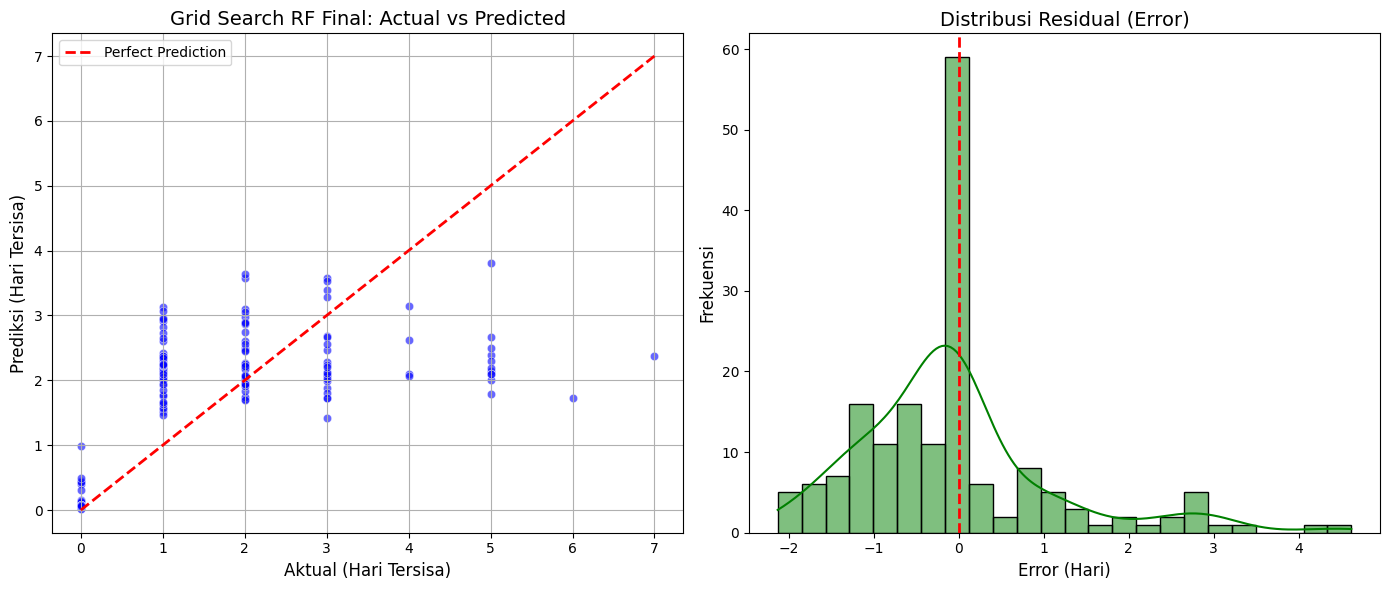

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_evaluasi(y_test, y_pred, model_name="Grid Search RF"):
    plt.figure(figsize=(14, 6))

    # Plot 1: Actual vs Predicted
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')

    max_val = max(y_test.max(), y_pred.max())
    min_val = min(y_test.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

    plt.title(f'{model_name}: Actual vs Predicted', fontsize=14)
    plt.xlabel('Aktual (Hari Tersisa)', fontsize=12)
    plt.ylabel('Prediksi (Hari Tersisa)', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Plot 2: Residuals
    residuals = y_test - y_pred
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True, color='green')
    plt.axvline(0, color='red', linestyle='--', lw=2)
    plt.title('Distribusi Residual (Error)', fontsize=14)
    plt.xlabel('Error (Hari)', fontsize=12)
    plt.ylabel('Frekuensi', fontsize=12)

    plt.tight_layout()
    plt.show()

y_pred_final = grid_search.predict(X_test)

print("Menampilkan visualisasi hasil evaluasi...")
plot_evaluasi(y_test, y_pred_final, model_name="Grid Search RF Final")

# **SIMPAN MODEL**

In [82]:
import joblib

# 1. Simpan Model
joblib.dump(tuned_model_grid, 'model_smart_waste.pkl')

print("Model berhasil disimpan! Siap dipindahkan ke website.")

Model berhasil disimpan! Siap dipindahkan ke website.


In [83]:
import shutil
import os

source_path = 'model_smart_waste.pkl'
destination_folder = '/content/drive/MyDrive/ML UAS/'

# Ensure the destination folder exists
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

destination_path = os.path.join(destination_folder, source_path)

try:
    shutil.move(source_path, destination_path)
    print(f"Model '{source_path}' berhasil dipindahkan ke '{destination_path}'")
except FileNotFoundError:
    print(f"Error: Model '{source_path}' tidak ditemukan di penyimpanan lokal Colab.")
except Exception as e:
    print(f"Terjadi kesalahan saat memindahkan model: {e}")


Model 'model_smart_waste.pkl' berhasil dipindahkan ke '/content/drive/MyDrive/ML UAS/model_smart_waste.pkl'
